# Introduction

In order to solve the problem of Titanic's passengers survival prediction I will use:
 - _Python 3.7.6_,
 - _pandas_ 1.0.5 (https://pandas.pydata.org/docs/) library,
 - _Scikit-learn_ 0.23.1 (https://scikit-learn.org/) library.

# Loading the data

Data from _test.csv_, _train.csv_ and _gender\_submission.csv_ can be loaded using read\_csv(path)_ function. Afterwards _test.csv_ and _gender\_submission.csv_ must be joined on column '_PassengerId_' so the output dataframe has the same schema as _train.csv_. Next, train and test dataframes can be concatenated to produce a dataframe with all rows that can be used for cross validation.

Scheme of dataframe in _Pandas_ can be checked using _dataframe.dtypes_ attribute. There are 12 columns in total. Meaning of each column is described on the website https://www.kaggle.com/c/titanic/data and is as follows:

| Variable      | Definition                                 | Key                                            |
|---------------|:------------------------------------------:|:----------------------------------------------:|
| Survival      | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass        | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex           | Sex                                        |                                                |
| Age           | Age in years                               |                                                |
| Parch         | # of siblings / spouses aboard the Titanic |                                                |
| SibSp         | # of parents / children aboard the Titanic |                                                |
| Ticket        | Ticket number                              |                                                |
| Fare          | Passenger fare                             |                                                |
| Cabin         | Cabin number                               |                                                |
| Embarked      | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

After loading the data I create the _all_ dataset by making a union of _test_ and _train_ datasets and changing their row ordering randomly by shuffling all the rows. At the same time I add a new column to all rows, called _File_, which indicates the origin of that row. Value '_Train_' in the _all_ dataset means that the given row comes from the _train_ dataset whereas value '_Test_' means that the given row comes from the _test_ dataset.

In [1]:
import pandas as pd
import numpy as np

tmp1            = pd.read_csv("test.csv")
tmp2            = pd.read_csv("gender_submission.csv")
train           = pd.read_csv("train.csv")
train['File']   = 'Train'
test            = pd.merge(left = tmp1, right = tmp2, left_on='PassengerId', right_on='PassengerId')
test['File']    = 'Test'
all             = pd.concat([train, test])
all             = all.sample(frac=1).reset_index(drop=True)
print(all.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
File            object
dtype: object


## Data quality check

The dataframe should be cleaned from any empty elements and elements that are not available (_NA_). Columns with missing values can be found using _dataframe.isna().any()_ function from _Pandas_. Quality of values in other columns can be verified by inspecting lists of values of all columns using the following function: _dataframe.groupby('column').size()_.

In [2]:
age             = all.groupby('Age').size()
passengerId     = all.groupby('PassengerId').size()
survived        = all.groupby('Survived').size()
pclass          = all.groupby('Pclass').size()
name            = all.groupby('Name').size()
sex             = all.groupby('Sex').size()
sibSp           = all.groupby('SibSp').size()
parch           = all.groupby('Parch').size()
ticket          = all.groupby('Ticket').size()
fare            = all.groupby('Fare').size()
cabin           = all.groupby('Cabin').size()
embarked        = all.groupby('Embarked').size()

print("Does the given column contain NULL/NA values?")
print(all.isna().any())

Does the given column contain NULL/NA values?
PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked        True
File           False
dtype: bool


# Data quality check - results

Here is the list of issues with data quality that were idenitifed by inspecting visually all columns:

1. there are missing values in the following columns:
    - _Age_,
    - _Fare_,
    - _Cabin_,
    - _Embarked_,
2. column _Ticket_ has mixed string and number values,
3. column _Cabin_ is empty for most rows while for others it contains a list of values that should be normalized, such as "C23 C25 C27",
4. column _Age_ has incoherent step value, e. g. there are 7 different values describing age in the range (0, 1); additionally step between most of the rows in _Year_ column is equal 1 most of the time but it is equal  0.5 for some values,
5. each value in column _Cabin_ is of form <_deck_><_room number_> where <_deck_> is a letter \[A-G, T\] and <_room number_> is an integer,
6. the following values in the _Name_ column are duplicated (there are 2 person in each case that have the same name but have different age and different tickets):
    - Connoly, Miss Kate,
    - Kelly, Mr James.

# Cleaning up the data

The above identified issues with the data quality will be addressed in the following subsection.

1. missing values will be treated for each column separetly:
    - missing values in column _Age_ will be replaced by the median of non-NaN values in that column,
    - missing values in column _Fare_ will be replaced by the median of non-NaN values in that column,
    - missing values in column _Cabin_ will be replaced by the room E60 which is arbitrarily assumed to be in the middle of the ship (see https://www.encyclopedia-titanica.org/titanic-deckplans/e-deck.html),
    - missing values in column _Embarked_ will be replaced arbitrarily by 'S' (Southampton).

In [3]:
all['Age'].fillna(all['Age'].median(), inplace=True)
all['Fare'].fillna(all['Fare'].median(), inplace=True)
all['Cabin'].fillna('E60', inplace=True)
all['Embarked'].fillna('S', inplace=True)

2. values in the _Ticket_ column will be stripped from any prefixes using the _re.sub(..)_ function. Please note that one value in this column ("_LINE_") does not have an integer suffix - it will be arbitrarily mapped to the integer value 0.

In [4]:
import re

def strip_prefix(x):
    if(x == 'LINE'):
        return 0
    else:
        return int(re.sub(r'^.* ', "", str(x)))

all['Ticket'] = all['Ticket'].apply(strip_prefix)

3. values in the _Cabin_ column will be split into separate rows,


In [5]:
# print(all['Cabin'].to_string())
all['Cabin'] = all['Cabin'].apply(lambda x: str(x))
all['Cabin'] = all['Cabin'].str.split(' ')
all = all.explode('Cabin')

4. _floor function_ should be applied to all values in the _Age_ column,

In [6]:
import math
all['Age'] = all['Age'].apply(math.floor)

5. _Cabin_ column will be split into _Deck_ and _Room_ columns. Any missing values in _Deck_ column will be arbitrarily mapped into _E_ deck (which was the middle deck on Titanic) whereas any missing values in the _Room_ column will be arbitrarily mapped into _60_ (which corresponds to the room halfway the ship).

In [7]:
import numpy as np

all[['Deck', 'Room']] = all['Cabin'].str.extract('(?P<Deck>[A-Z])(?P<Room>[0-9]*)', expand=True)
all['Deck'].replace('', np.nan, inplace=True)
all['Room'].replace('', np.nan, inplace=True)
all['Deck'].fillna('F', inplace=True)
all['Room'].fillna('60', inplace=True)

6. column _Name_ isn't a good candidate for a feature anyway (by intuition) so I will not deal with the fact that it contains a few passengers with the same names.

# Encoding all values into intervals

The following columns have string type: _Sex_, _Cabin_, _Embarked_, _Deck_, _Room_ whereas the column _Fare_ has float type. Additionally, the _Ticket_ column of type int has huge gaps between its values. In order to encode all values into a continous interval that would be more convenient as the input for a classifier, _preprocessing.OrdinalEncoder_ from the _Scikit-Learn_ library will be used.

Additionally, _preprocessing.Scaler_ of _Scikit-Learn_ will be used in order to transform all the column of _all_ dataframe except for '_PassengerId_', '_Cabin_', '_Name_', '_File_', '_Survived_' in the following way: **z = (x - u) / s**, where **z** is the new value in the column, **x** is the old value, **u** is the mean of the column, **s** is the standard deviation of the column.

In [8]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

encoder = OrdinalEncoder()

tmp = all.drop(['PassengerId', 'Cabin', 'Name', 'File', 'Survived'], axis=1)

encoder.fit(tmp)
tmp = pd.DataFrame(encoder.transform(tmp), columns=tmp.columns)

scaler = StandardScaler()
print(scaler.fit(tmp.drop(['Sex'], axis=1)))
tmp1 = pd.DataFrame(scaler.transform(tmp.drop(['Sex'], axis=1)), columns=tmp.drop(['Sex'], axis=1).columns)

tmp1['Sex'] = tmp['Sex']
tmp1[['PassengerId', 'Cabin', 'Name', 'File', 'Survived']] = all[['PassengerId', 'Cabin', 'Name', 'File', 'Survived']].reset_index(drop=True)
all = tmp1

StandardScaler()


# Analysis of feature correlations

After preprocessing data we are ready to analyze Pearson correlation coefficients between pairs of features. Below is shown a heatmap of all those values whose absolute values was greater or equal 0.3 which is the arbirtral threshold of significant correlation.

Pclass       Age     SibSp     Parch    Ticket      Fare  Embarked      Deck      Room       Sex  Survived
Pclass         NaN -0.369119       NaN       NaN  0.351762 -0.753054       NaN  0.663274  0.384200       NaN       NaN
Age      -0.369119       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN
SibSp          NaN       NaN       NaN  0.413835       NaN  0.386860       NaN       NaN       NaN       NaN       NaN
Parch          NaN       NaN  0.413835       NaN       NaN  0.416851       NaN       NaN       NaN       NaN       NaN
Ticket    0.351762       NaN       NaN       NaN       NaN -0.347005  0.336603       NaN       NaN       NaN       NaN
Fare     -0.753054       NaN  0.386860  0.416851 -0.347005       NaN       NaN -0.560657       NaN       NaN  0.312713
Embarked       NaN       NaN       NaN       NaN  0.336603       NaN       NaN       NaN       NaN       NaN       NaN
Deck      0.663274       NaN       NaN       NaN       NaN -

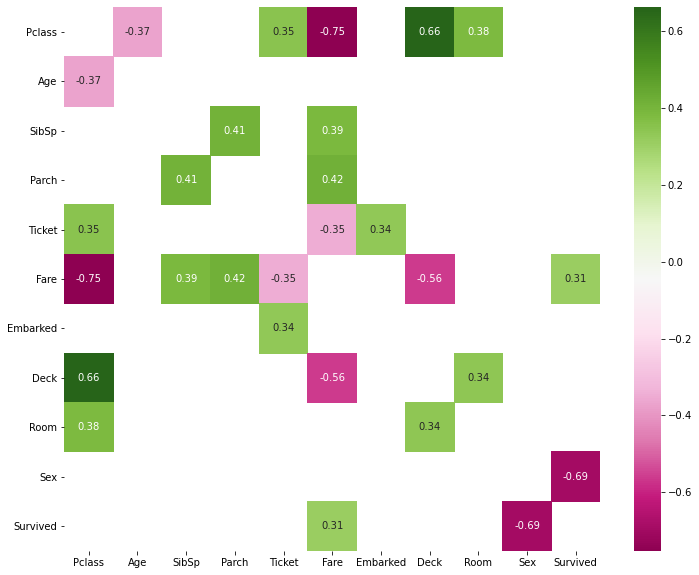

Sex / Survived for test data:
Survived  Sex
0         1.0    280
1         0.0    165
dtype: int64

Sex / Survived for train data:
Survived  Sex
0         0.0     83
          1.0    479
1         0.0    248
          1.0    115
dtype: int64

Sex / Survived for all data:
Survived  Sex
0         0.0     83
          1.0    759
1         0.0    413
          1.0    115
dtype: int64


In [9]:
## Correlation between different features

import matplotlib.pyplot as plt
import seaborn as sns

tmp = all.drop(['PassengerId', 'Cabin', 'Name'], axis=1)

correlation = tmp.corr()

# #Selecting highly correlated features
relevant_features = correlation[(0.3 <= abs(correlation)) & (abs(correlation) < 1)].dropna(axis=1, how='all').dropna(axis=0, how='all')
# relevant_features
print(relevant_features.to_string())
plt.figure(figsize=(12,10))
sns.heatmap(relevant_features, annot=True, cmap="PiYG")
plt.show()

train   = all[all['File'] == 'Train']
test    = all[all['File'] == 'Test']

print("Sex / Survived for test data:")
print(test.groupby(['Survived', 'Sex']).size())
print("\nSex / Survived for train data:")
print(train.groupby(['Survived', 'Sex']).size())
print("\nSex / Survived for all data:")
print(all.groupby(['Survived', 'Sex']).size())

It can be seen that the top 5 strongly correlated features are:
 - Fare, Pclass (-0.75) - i. e. _ticket price_ and _ticket class_,
 - Survived, Sex (-0.69) - i. e. _if a given person survived_ and _their sex_,
 - Pclass, Deck (0.66) - i. e. _ticket class_ and the _deck_ that corresponded to the ticket,
 - Fare, Deck (-0.56) - i. e. _ticket price_ and the _deck_ that corresponded to the ticket,
 - Parch, Fare (0.42) - i. e. _number of siblings / spouses aboard the Titanic_ and _ticket price_.
 
Additionally, there is weak correspondence between the _Fare_ and _Survived_ columns (correlation coefficient: 0.31).

It is quite surprising to see that _Age_ did not play the key role in survining on the Titanic. At the same time, females tended to have more probability of surivial than men (see the table below).

|                     | deaths | survived |
|---------------------|--------|----------|
| males (test.csv)    | 280    | 0        |
| females (test.csv)  | 0      | 165      |
| males (train.csv)   | 479    | 115      |
| females (train.csv) | 83     | 248      |
| males (all)         | 759    | 115      |
| females (all)       | 83     | 413      |

It is worth noting that the data in _test.csv_ is biased when it comes to male/female death comparison. The feature most correlated to survival - which is _Sex_ - is distributed in this dataset in such a way that there are no females who died and no males who survived. This makes validation using this dataset quiet disputable. In order to achieve reliable results, _train_ and _test_ datasets should be unioned and then randomly split into two sets again. Otherwise, the classifier might tend to perform very well only on the test data from _test.csv_. It could perform very bad given data that are not biased in this way.

Additionally, cross-validation should be used in order to make the training set independent from the way its elements have been chosen (https://en.wikipedia.org/wiki/Cross-validation_(statistics)).

# Analyzed models

The models used to solve the problem of Titanic passengers survival prediction will be the following:

1. logistic regression classifier (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html),
2. k-nearest neighbors classifier using the following number of neighbors used by the algorithm: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20 (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html),
3. support vector machines using _RBF_ and _polynomial_ kernels (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

I choose _Fare_, _Sex_, _Deck_ and _Pclass_ as features to feed those models.

#### Quality of prediction

For each classifier the overall quality of prediction will be measured in four ways:
 - as the average of _f1_ score on the training subset across all 4 splits during cross-validation,
 - as the _f1_ score for the _train_ dataset (the one from _test.csv_ file).
 - as the ROC characteristic (https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the _test_ dataframe,
 - as the ROC characteristic for the same random sample of 343 rows for all 4 classifiers,

where _f1_ metric (https://en.wikipedia.org/wiki/F1_score) - is the harmonic mean between _precision_ and _recall_.

I will use 4-cross-validation to train all the models. The _train_ and _test_ datasets will be chosen randomly from the union of _test.csv_ and _train.csv_.

In [10]:
## logistic regression

import functools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

features        = ['Sex', 'Pclass', 'Deck', 'Fare']
c_range         = [0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0]
param_grid      = dict(C=c_range)

print(param_grid)

from sklearn.model_selection import train_test_split
train, test = train_test_split(all, test_size=0.25)
# train   = all[all['File'] == 'Train']
# test    = all[all['File'] == 'Test']

cv = ShuffleSplit(n_splits=4, test_size=0.25, random_state=42)
lr = LogisticRegression()
lr_grid = GridSearchCV(lr, param_grid=param_grid, cv=cv, scoring='f1', return_train_score=True)
lr_grid.fit(train[features], train['Survived'])
y_scores = lr_grid.predict_proba(test[features])

lr_fpr, lr_tpr, lr_threshold = roc_curve(y_true=test['Survived'], y_score=y_scores[:, 1])
lr_auc = auc(lr_fpr, lr_tpr)

# for (l,r) in zip(lr_fpr, lr_tpr):
#       print(l, r)

# for (l,r) in zip(test['Survived'], y_scores[:, 1]):
#       print(l, r)

means       = list(filter(lambda x: pd.notna(x), lr_grid.cv_results_['mean_test_score']))
stds        = list(filter(lambda x: pd.notna(x), lr_grid.cv_results_['std_test_score']))
means_stds  = list(zip(means, stds))
maximum = functools.reduce(lambda l,r: l if l[0] > r[0] else r, means_stds)

print('AUC of LR = ' + str(lr_auc))
print("f1 mean for cross-validation: " + str(maximum[0]) + ", standard deviation: " + str(maximum[1]))    
print("f1 for test data: " + str(lr_grid.score(X=test[features], y=test['Survived'])))
print("the best parameters are %s "
      % (lr_grid.best_params_))

{'C': [0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0]}
AUC of LR = 0.9022752293577982
f1 mean for cross-validation: 0.8130776981738685, standard deviation: 0.023153534301646614
f1 for test data: 0.810126582278481
the best parameters are {'C': 0.25} 


In [11]:
# k-nearest neighbors classifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid      = dict(n_neighbors=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20], algorithm=['ball_tree', 'kd_tree', 'brute'], weights=['uniform', 'distance'])

cv = ShuffleSplit(n_splits=4, test_size=0.25, random_state=42)
grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=cv, scoring='f1')
grid.fit(train[features], train['Survived'])

means       = list(filter(lambda x: pd.notna(x), grid.cv_results_['mean_test_score']))
stds        = list(filter(lambda x: pd.notna(x), grid.cv_results_['std_test_score']))
means_stds  = list(zip(means, stds))
maximum = functools.reduce(lambda l,r: l if l[0] > r[0] else r, means_stds)

y_scores = grid.predict_proba(test[features])
knn_fpr, knn_tpr, knn_threshold = roc_curve(test['Survived'], y_scores[:, 1])
knn_auc = auc(knn_fpr, knn_tpr)

print('AUC of KNN = ' + str(knn_auc))
print("f1 mean for cross-validation: " + str(maximum[0]) + ", standard deviation: " + str(maximum[1]))    
print("f1 for test data: " + str(grid.score(X=test[features], y=test['Survived'])))
print("the best parameters are %s "
      % (grid.best_params_))

AUC of KNN = 0.8998165137614678
f1 mean for cross-validation: 0.8230627769939116, standard deviation: 0.022485102232376535
f1 for test data: 0.8177777777777778
the best parameters are {'algorithm': 'brute', 'n_neighbors': 10, 'weights': 'uniform'} 


In [12]:
# support vector machines
# warning! it take a few minutes to execute the below code!

from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

###     RBF kernel    ###
# vvvvvvvvvvvvvvvvvvvvvvv

gammas          = np.union1d([0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0], ['auto', 'scale'])
c_range         = [0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0]

param_grid      = dict(gamma=gammas, C=c_range)
cv = ShuffleSplit(n_splits=4, test_size=0.25, random_state=42)
grid = GridSearchCV(SVC(kernel='rbf', probability=True), param_grid=param_grid, cv=cv, scoring='f1')
grid.fit(train[features], train['Survived'])
y_scores = grid.predict_proba(test[features])
svm_rbf_fpr, svm_rbf_tpr, svm_rbf_threshold = roc_curve(test['Survived'], y_scores[:, 1])
svm_rbf_auc = auc(svm_rbf_fpr, svm_rbf_tpr)

means       = list(filter(lambda x: pd.notna(x), grid.cv_results_['mean_test_score']))
stds        = list(filter(lambda x: pd.notna(x), grid.cv_results_['std_test_score']))
means_stds  = list(zip(means, stds))
maximum = functools.reduce(lambda l,r: l if l[0] > r[0] else r, means_stds)

print('AUC of SVM RBF = ' + str(svm_rbf_auc))
print("f1 mean for cross-validation: " + str(maximum[0]) + ", standard deviation: " + str(maximum[1]))    
print("f1 for test data: " + str(grid.score(X=test[features], y=test['Survived'])))
print("the best parameters are %s "
      % (grid.best_params_))
print("\n")

# ^^^^^^^^^^^^^^^^^^^^^ #
###     RBF kernel    ###



### polynomial kernel ###
# vvvvvvvvvvvvvvvvvvvvvvv

svm_poly_param_grid      = dict(gamma=gammas, degree=[2, 2, 3, 4, 5, 6, 7], C=c_range)
# print(param_grid)
svm_poly_cv = ShuffleSplit(n_splits=4, test_size=0.25, random_state=42)
svm_poly_grid = GridSearchCV(SVC(kernel='poly', probability=True), param_grid=svm_poly_param_grid, cv=svm_poly_cv, scoring='f1')
svm_poly_grid.fit(train[features], train['Survived'])
y_scores = svm_poly_grid.predict_proba(test[features])
svm_poly_fpr, svm_poly_tpr, svm_poly_threshold = roc_curve(test['Survived'], y_scores[:, 1])
svm_poly_auc = auc(svm_poly_fpr, svm_poly_tpr)

means       = list(filter(lambda x: pd.notna(x), svm_poly_grid.cv_results_['mean_test_score']))
stds        = list(filter(lambda x: pd.notna(x), svm_poly_grid.cv_results_['std_test_score']))
means_stds  = list(zip(means, stds))
maximum = functools.reduce(lambda l,r: l if l[0] > r[0] else r, means_stds)

print('AUC of SVM poly = ' + str(svm_poly_auc))
print("f1 mean for cross-validation: " + str(maximum[0]) + ", standard deviation: " + str(maximum[1]))    
print("f1 for test data: " + str(svm_poly_grid.score(X=test[features], y=test['Survived'])))
print("the best parameters are %s "
      % (svm_poly_grid.best_params_))

# ^^^^^^^^^^^^^^^^^^^^^ #
### polynomial kernel ###

AUC of SVM RBF = 0.8866055045871559
f1 mean for cross-validation: 0.8130776981738685, standard deviation: 0.023153534301646614
f1 for test data: 0.810126582278481
the best parameters are {'C': 0.25, 'gamma': 'auto'} 


AUC of SVM poly = 0.8727339449541284
f1 mean for cross-validation: 0.8157368970351067, standard deviation: 0.024718204698407315
f1 for test data: 0.803347280334728
the best parameters are {'C': 0.5, 'degree': 3, 'gamma': 'auto'} 


# Results

The below table shows results for each classifier. The figure under the table depicts _receiver operating characteristics_ for the _test_ dataset.

Warning! Please keep in mind that the below data were obtained for a testing dataset obtained as a random sample of 343 rows from the union of _train.csv_ and _test.csv_.

| Model (best fit)            | Scikit-Learn class   | Best model's parameters                                        | Mean of F1 across all folds during 4-cross-validation | F1 for test data | AUC for test data |
|-----------------------------|----------------------|----------------------------------------------------------------|-------------------------------------------------------|------------------|-------------------|
| Logistic Regression         | LogisticRegression   | {'C': 0.25}                                                    | 0.81 +/- 0.023                                        | 0.81             | 0.9               |
| K-nearest Neigbors          | KNeighborsClassifier | {'algorithm': 'brute', 'n_neigbors': 10, 'weights': 'uniform'} | 0.82 +/- 0.022                                        | 0.82             | 0.9               |
| SVM with RBF kernels        | SVC(kernel='rbf)     | ['C': 0.25, 'gamma': 'auto'}                                   | 0.81 +/- 0.023                                        | 0.81             | 0.89              |
| SVM with polynomial kernels | SVC(kernel='poly')   | ['C': 0.5, 'degree'=3, 'gamma': 'auto'}                        | 0.82 +/- 0.025                                        | 0.80             | 0.87              |

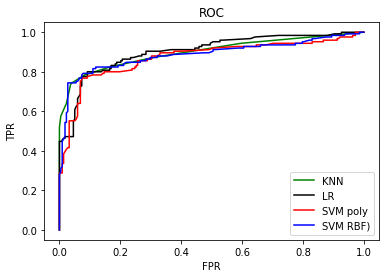

In [13]:

plt.plot(knn_fpr, knn_tpr, 'g', label="KNN")
plt.plot(lr_fpr, lr_tpr, 'black', label="LR")
plt.plot(svm_poly_fpr, svm_poly_tpr, 'r', label="SVM poly")
plt.plot(svm_rbf_fpr, svm_rbf_tpr, 'b', label="SVM RBF)")
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc="lower right")
plt.show()


# Summary

Logistic regression and k-nearest neighbors classifier performed slightly better on this testing dataset than SVMs. It is hard to tell if it this relation is statistically significant, but determining which classifier performs the best is out of scope of this assignment. More diverse data would be needed to make an unambigious statement. At this point it is worth noting again that in order to achieve reliable results, mixing _test.csv_ with _train.csv_ and shuffling of data were required. The original _test_ dataset contained unbalanced data (no females that died and no men that survived).

In any case, it has been proven that achieving _f1_ score equal to around _0.9_ is possible using any of the above classifiers.

Estimating the survival of Titanic passengers is possible using _predict-proba(..)_ function available for all classifiers in _Scikit-learn_. For binary classification, it is common toassume that the threshold between the binary classes is 0.5.